In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
import torch
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd 
import glob

sys.path.insert(1, sys.path[0] + '/..')
from src.data.utils import simplify_labels
from src.model.setup import setup_model
from src.misc.files import get_boxes
from src.postprocess import _post_process
from src.postprocess import main as postprocess_main, parse_option as postprocess_parse_option
from src.data.utils import pad_tensor
from src.run import parse_option, main
from src.misc.gridsearch import gridsearch
from src.misc.plot import plot_results, plot_gridsearch

args = parse_option(notebook=True)

Preprocess

In [2]:
os.chdir('../src')
os.system('python preprocess.py --split val --data ../data_dev')
os.system('python preprocess.py --split train --data ../data_dev')
os.chdir('../notebooks')

Namespace(data_dir='../data_dev', patch_size=[128, 128, 128], split='val')
Splitting val data into patches and creating bounding boxes...


100%|██████████| 2/2 [00:38<00:00, 19.28s/it]


Namespace(data_dir='../data_dev', patch_size=[128, 128, 128], split='train')
Splitting train data into patches and creating bounding boxes...


100%|██████████| 2/2 [00:32<00:00, 16.29s/it]


Train

> **We only train it now on a tiny dataset for only a few epochs, so the results are not representative. However, if one takes all data into account and train for sufficient epochs, one obtains the same results as shown in the report!**


In [3]:
args.train, args.predict = True, False
args.splits = ['train', 'val']
args.data = '../data_dev'
args.max_epochs = 2
main(args)

Global seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/elias/anaconda3/envs/ribfrac/lib/python3.8/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name | Type              | Params
-------------------------------------------
0 | net  | FracNet           | 1.4 M 
1 | loss | BCEWithIgnoreLoss | 0     
-------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.606     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/elias/anaconda3/envs/ribfrac/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/elias/anaconda3/envs/ribfrac/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 1: 100%|██████████| 4/4 [00:32<00:00,  8.00s/it, v_num=on_0, train_loss=2.170, train_acc=0.833, val_loss=0.584, val_acc=0.682]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 4/4 [00:32<00:00,  8.01s/it, v_num=on_0, train_loss=2.170, train_acc=0.833, val_loss=0.584, val_acc=0.682]


Predict

In [4]:
# Predict arguments
args.train, args.predict = False, True
args.splits = ['train']

# Postprocess arguments
postprocess_args = postprocess_parse_option(notebook=True)
postprocess_args.split = args.splits[0]
postprocess_args.prediction_box_dir = os.path.join(args.log_dir, args.net, args.version, 'segmentations')
postprocess_args.original_image_dir = args.data_dir
postprocess_args.save_dir = os.path.join(args.log_dir, 'submissions', args.version, postprocess_args.split)

In [5]:
# Load data
y_true = get_boxes(os.path.join(postprocess_args.original_image_dir, 'boxes', postprocess_args.split, 'labels'))
x_img     = get_boxes(os.path.join(postprocess_args.original_image_dir, 'boxes', postprocess_args.split, 'images'))

# Load trained
trained_unet = setup_model(args)

# Custom predict, as we are only interested in the segmentation, not in the full stiched image
y_pred = []
for x_i in tqdm(x_img):
    xx = pad_tensor(torch.tensor(x_i), 0, 64).unsqueeze(0)
    yy = torch.tensor([-1])
    batch = (xx, yy)

    xx_pred, _ = trained_unet(batch)
    xx_pred = xx_pred.squeeze(0).detach().numpy()
    y_pred.append(xx_pred)


100%|██████████| 12/12 [00:06<00:00,  1.77it/s]


In [6]:
gs_max = pd.DataFrame(data = [[0.868687, 0.]], columns=['prob_thresh', 'size_thresh']) # Pick some threshold values, for these values see the report

Post process

In [7]:
# Custom post process, as we are only interested in the segmentation, not in the full stiched image
data = []
for i, j, k in zip(x_img, y_true, y_pred):
    s = np.array(i.shape)
    idxs = tuple([slice(0, s_i) for s_i in i.shape])
    p = k[idxs]

    # Postprocessing
    p_post = p.copy()
    p_post = _post_process(pred = p, image = i, prob_thresh=gs_max.iloc[0]['prob_thresh'], bone_thresh=None, size_thresh=gs_max.iloc[0]['size_thresh'])
    p_post = simplify_labels(p_post)*1.

    j = simplify_labels(j)

    data.append( {'img': i, 'label': j, 'pred' : p, 'pred_post': p_post, } )

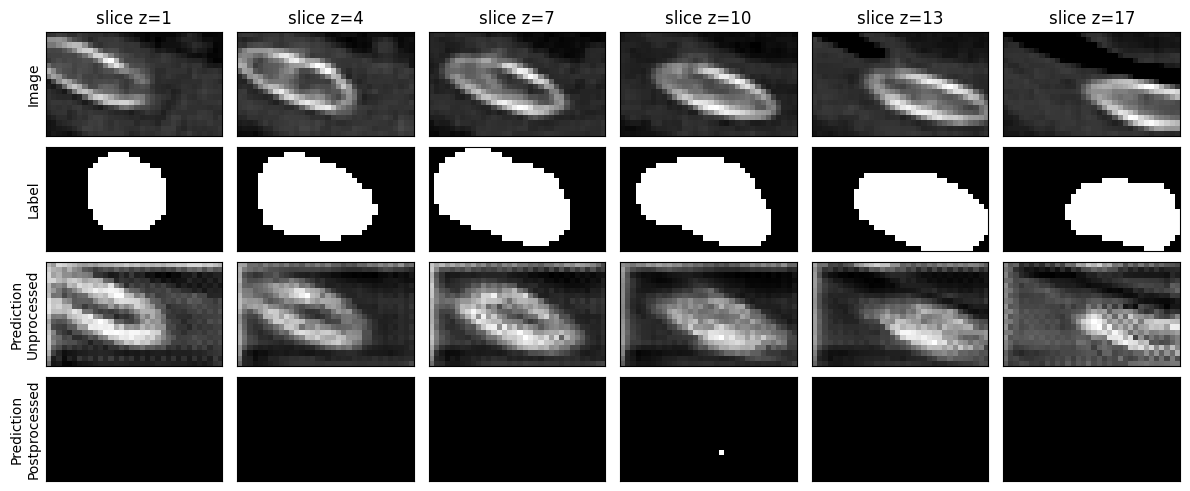

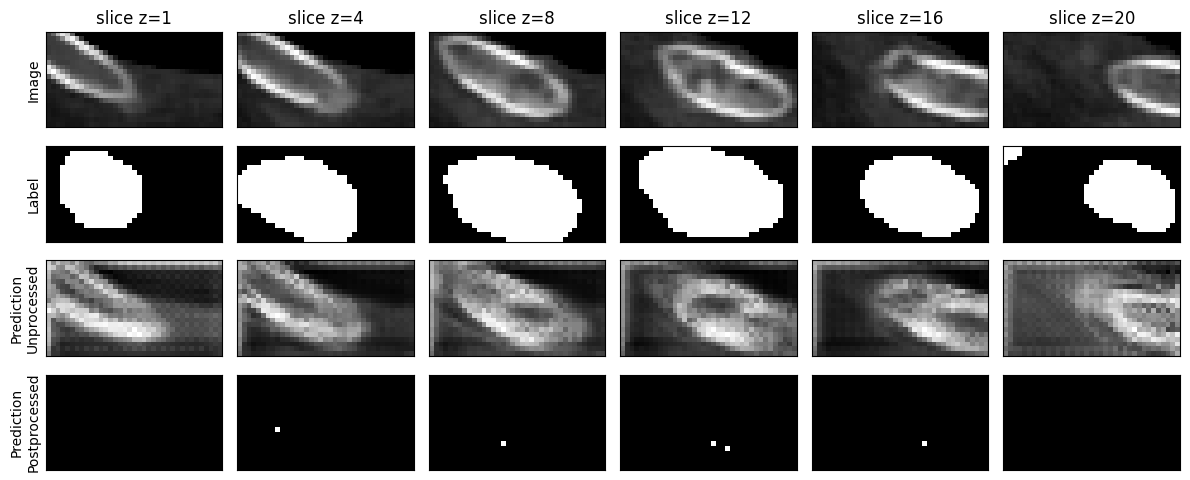

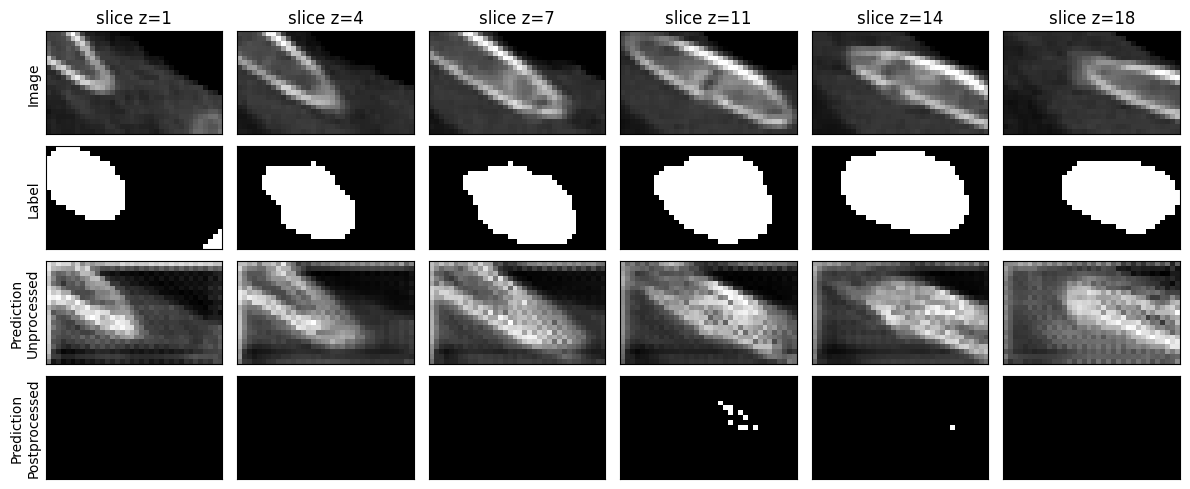

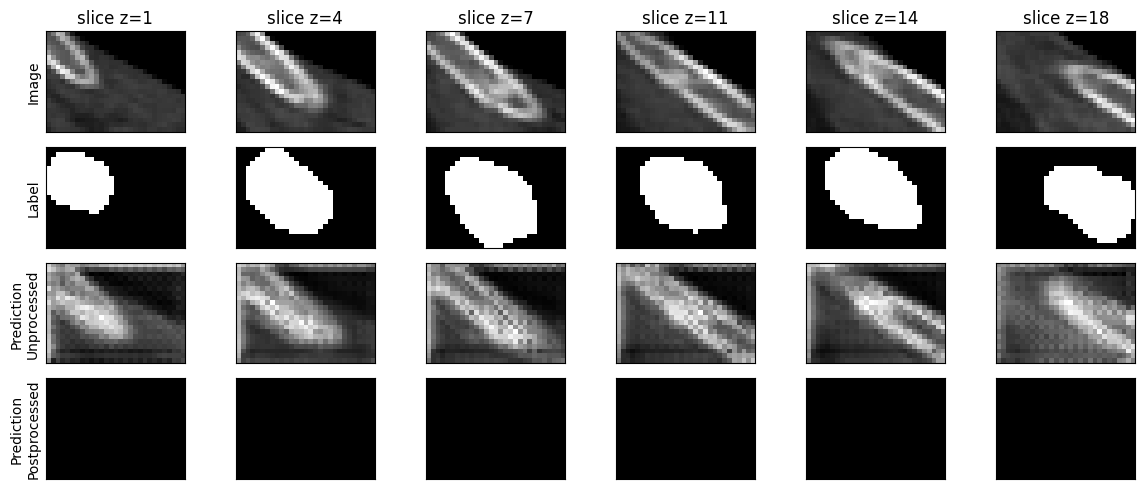

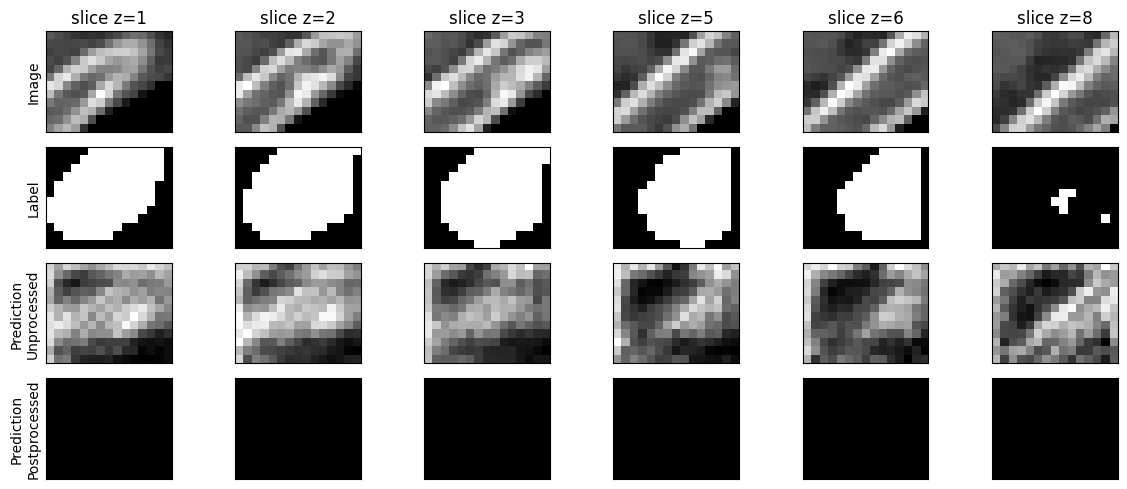

In [8]:
plot_results(data)

Gridsearch

In [9]:
gs = gridsearch(data)

100%|██████████| 10100/10100 [00:02<00:00, 3996.78it/s]


Analysis

In [10]:
# find indecies where recall is max
gs_max = gs[gs['precision_mean'] == gs['precision_mean'].max()]
gs_max

,prob_thresh,bone_thresh,size_thresh,accuracy,precision,recall,accuracy_mean,precision_mean,recall_mean,accuracy_std,precision_std,recall_std
8282,0.828283,200.0,0.0,"[0.5861111283302307, 0.5500643253326416, 0.642...","[0.95652174949646, 0.9870129823684692, 0.97619...","[0.004324749577790499, 0.010754209943115711, 0...",0.604177,0.780048,0.020626,0.072827,0.361399,0.033012


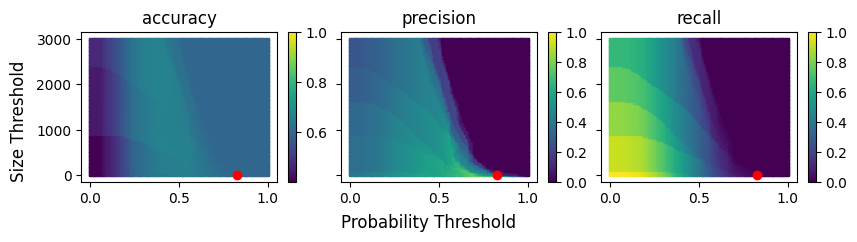

In [11]:
plot_gridsearch(gs, gs_max)